# Experiments

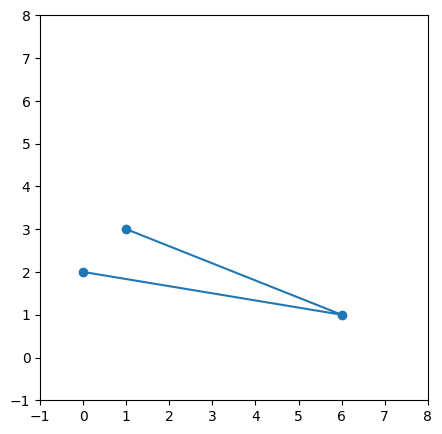

In [2]:
import numpy as np
import matplotlib.pyplot as plt

p1 = np.array([1,3])
p2 = np.array([6,1])
p3 = np.array([0,2])

pts = np.array([p1, p2, p3])
x = pts.T[0]
y = pts.T[1]

plt.figure(figsize=(5,5))
plt.axis([-1, 8, -1, 8])
plt.plot(x, y)
plt.scatter(x, y)
plt.show()

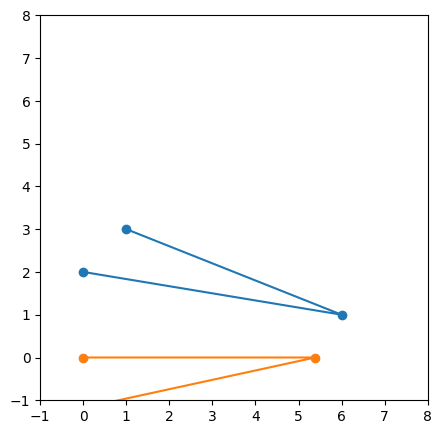

In [3]:
#choosing which point is the origin for edge aligned bounding box
#leftmost in x or if equal x, the highest point
if p1[0] != p2[0]:
    o = p1 if p1[0] < p2[0] else p2
    p = p2 if p1[0] < p2[0] else p1
else:
    o = p1 if p1[1] > p2[1] else p2
    p = p2 if p1[1] > p2[1] else p1

#transformation
T = o
#for all points of the edge and obstacle...
o = o - T
p = p - T
p3_r = p3 - T

#rotation
angle = np.arccos(np.dot([p[0],0], p)/(p[0] * np.linalg.norm(p))) # standard vector angle formula
R = np.array([[np.cos(angle), -np.sin(angle)],
              [np.sin(angle), np.cos(angle)]]) # 2d rotation matrix construction

p = np.matmul(R, p) #multiplying by rotation matrix gives new coordinates
p3_r = np.matmul(R, p3_r)

ptz = np.array([o,p, p3_r])

plt.figure(figsize=(5,5))
plt.axis([-1, 8, -1, 8])
plt.plot(x, y)
plt.scatter(x, y)
plt.plot(ptz.T[0], ptz.T[1])
plt.scatter(ptz.T[0], ptz.T[1])
plt.show()

In [4]:
r = 0.1

def bbox(obs):
    min_x, max_x, min_y, max_y = ([0]*4)
    if len(obs) == 1:
        obs = obs[0]
        min_x = obs[0] - r
        max_x = obs[0] + r
        min_y = obs[1] - r
        max_y = obs[1] + r
    else:
        min_x = np.min(obs.T[0])
        max_x = np.max(obs.T[0])
        min_y = np.min(obs.T[1])
        max_y = np.max(obs.T[1])


    return min_x, max_x, min_y, max_y

In [5]:
bbox(np.array([[0,0]]))

(-0.1, 0.1, -0.1, 0.1)

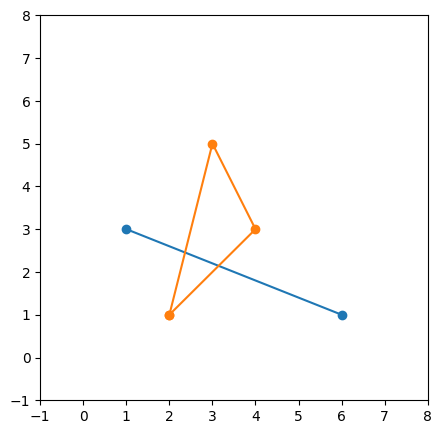

In [6]:
p1 = np.array([1,3])
p2 = np.array([6,1])
edge = np.array([p1, p2])

triangle = np.array([[2,1], [4,3], [3,5], [2,1]])


plt.figure(figsize=(5,5))
plt.axis([-1, 8, -1, 8])

plt.plot(edge.T[0], edge.T[1])
plt.scatter(edge.T[0], edge.T[1])

plt.plot(triangle.T[0], triangle.T[1])
plt.scatter(triangle.T[0], triangle.T[1])

# min_x, max_x, min_y, max_y = bbox(triangle)

# corners = []
# for xs in [min_x, max_x]:
#     for ys in [min_y, max_y]:
#         corners.append([xs, ys])
# corners = np.array(corners)

# plt.plot(corners.T[0], corners.T[1])
# plt.scatter(corners.T[0], corners.T[1])

# corners_r = np.matmul(R, corners.T).T
# plt.scatter(corners_r.T[0], corners_r.T[1])


plt.show()

# Edge-Aligned Bounding Box (EABB)
Given:
- edge (p1, p2)
- an (intersecting) obstacle:
  - a list containing a single point representing another location 
  - OR a list of points representing a polygonal obstacle

In [7]:
# the radius of a location, maximum line width in the graph?
r = 0.5
# the buffer around obstacles
BUFFER = 0.0

In [8]:
def vecAngle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2)))

In [20]:
# straightforward implementation
def aabb(obs, lw):
    if len(obs) == 1:
        obs = obs[0]
        min_x = obs[0] - lw - r - BUFFER
        max_x = obs[0] + lw + r + BUFFER
        min_y = obs[1] - lw - r - BUFFER
        max_y = obs[1] + lw + r + BUFFER
    else: # obs.T[0] gets all x values, obs.T[1] the y values
        min_x = np.min(obs.T[0]) - lw - BUFFER
        max_x = np.max(obs.T[0]) + lw + BUFFER
        min_y = np.min(obs.T[1]) - lw - BUFFER
        max_y = np.max(obs.T[1]) + lw + BUFFER

    #get the corners of the bounding box
    corners = []
    for x in [min_x, max_x]:
        for y in [min_y, max_y]:
            corners.append([x,y])
    corners = np.array(corners)

    return corners

In [26]:
def eabb(edge, obs, lw):
    #to make sure they are easy to work with
    edge = np.array(edge)
    obs = np.array(obs)

    #choosing which point is the origin in the new coordinate system
    #leftmost in x or if equal x, the highest point
    if edge[0][0] != edge[1][0]:
        p1 = edge[0] if edge[0][0] < edge[1][0] else edge[1]
        p2 = edge[1] if edge[0][0] < edge[1][0] else edge[0]
    else:
        p1 = edge[0] if edge[0][1] > edge[1][1] else edge[1]
        p2 = edge[1] if edge[0][1] > edge[1][1] else edge[0]

    '''TRANSLATION'''
    translation = p1 #the translation vector
    
    #translate
    p1 = p1 - translation #will be origin
    p2 = p2 - translation
    obs = obs - translation

    '''ROTATION'''
    # standard vector angle formula: arccos(a dot b / (|a| * |b|))
    angle = vecAngle([p2[0], 0], p2)
    if p2[1] > 0:
        angle = -angle

    
    # 2d rotation matrix construction: ((cos -sin), (sin cos))
    rotation = np.array([[np.cos(angle), -np.sin(angle)],
                         [np.sin(angle),  np.cos(angle)]])

    #rotate the obstacle into the new coordinate system
    obs_r = np.matmul(rotation, obs.T).T

    '''OBSTACLE BOUNDING BOX'''
    #get axis aligned bounding box in this coordinate system
    corners_r = aabb(obs_r, lw)

    #rotate them back into the old coordinate system
    #transpose is inverse of a rotation matrix
    corners = np.matmul(rotation.T, corners_r.T).T + translation
    
    return corners

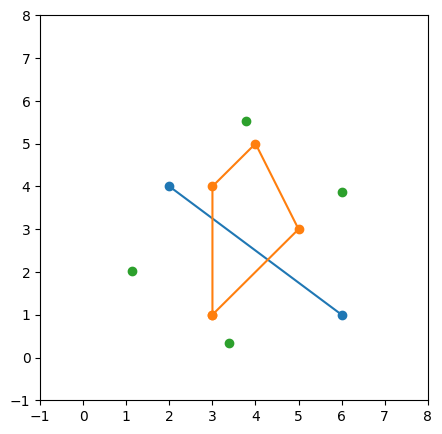

In [27]:
p1 = np.array([2,4])
p2 = np.array([6,1])
edge = np.array([p1, p2])
obstacle = np.array([[3,1], [5,3], [4,5], [3,4], [3,1]])
# obstacle = np.array([[3, 2.5]])

corners = eabb([p1, p2], obstacle, 0.3)

plt.figure(figsize=(5,5))
plt.axis([-1, 8, -1, 8])

plt.plot(edge.T[0], edge.T[1])
plt.scatter(edge.T[0], edge.T[1])

plt.plot(obstacle.T[0], obstacle.T[1])
plt.scatter(obstacle.T[0], obstacle.T[1])

# plt.plot(triangle.T[0], triangle.T[1])
plt.scatter(corners.T[0], corners.T[1])

plt.show()

detection:
    for each edge (not hyperedge?) sorted high to low by weight
        if edge already checked: skip
        for each obstacle
            if obstacle *not* outside of axis-aligned bounding box of the edge: skip
            else if 
                if obstacle is another location
                    if distance from location to edge (minus radius around location) is less than some threshold
                        bend with the edge and obstacle in mind
                if obstacle is some polygon
                    if distance from closest polygon point to edge is less than some threshold
                        bend with the edge and obstacle in mind

bending:
    find the bounding box aligned with the edge:
        (perform translations and rotations)
        bounding box is lowest and highest x and y of the obstacle
        (for locations, the coordinates +&- radius)
        the line goes through two corners of the bounding box: the one with smallest |y| in the rotated scenario